In [2]:
!pip install torch_snippets torchsummary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 127.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 43.7 MB/s eta 0:00:00
   ━━━━

In [3]:
!pip install umap-learn markitdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 119.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 118.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.5 MB/s eta 0:00:00


In [4]:
import math
from glob import glob
import seaborn as sns
from torchsummary import summary
from torch_snippets import *
from torch_snippets.torch_loader import Report
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage import io
from sklearn.metrics import cohen_kappa_score
import torch.nn.functional as F
import cv2
import umap
import gc
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import torch
from torch import nn
#is GPU available?
gpu = torch.cuda.is_available()

#defining device where to to the computation
device = torch.device(0) if gpu else torch.device('cpu')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
orig_dir   = '/content/drive/MyDrive/appsheet/Arquivos Colab/mo434/larvae'
nclasses   = 2

width       = 224
height      = 224
nchannels   = 3
maxval      = 255.
input_shape = (nchannels,height,width)

data = glob(orig_dir+"/*.png")

# Extract labels from filenames (0 for class 1, 1 for class 2)
# This is crucial for the 'stratify' parameter
labels = [int(f.split('/')[-1].split('_')[0]) - 1 for f in data]

# The 'stratify=labels' argument ensures both sets have the same class proportion
train_val_files, testset, train_val_labels, _ = train_test_split(
    data, labels, test_size=0.30, random_state=42, stratify=labels)

# now we split the temporary 70% set into the final training and validation sets.
# The validation set is 0.20 of the original total, which is 0.20/0.70 of this temporary set.
val_size_relative = 0.20 / (0.50 + 0.20)
trainset, validset, _, _ = train_test_split(
    train_val_files, train_val_labels, test_size=val_size_relative, random_state=42, stratify=train_val_labels)


# verifying
print(f"Total: {len(data)}")
print(f"Training: {len(trainset)}")
print(f"Validation: {len(validset)}")
print(f"Test: {len(testset)}")

# Set output model name
model_name  = 'LarvaeCNN.pth'

Total: 1598
Training: 798
Validation: 320
Test: 480


In [7]:
# Regular preprocessing transformation. The input is a PIL image, which after being resized,
# it is converted into a tensor for normalization using the ImageNet mean and stdev parameters.

prep = transforms.Compose([
    transforms.Resize((height,width), interpolation=transforms.InterpolationMode.BILINEAR,
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Such transformations are applied everytime images are loaded from the filename lists in training, validation,
# and test sets. We will do that during training, then by adding affine transformations and increasing the number 3
# of epochs, we are actually implementing data augmentation.

aug = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.05,0.10), scale=(0.9,1.1), shear=(-2,2),
                            interpolation=transforms.InterpolationMode.BILINEAR,
                            fill=0),
    transforms.CenterCrop(250),
    transforms.Resize((height,width), interpolation=transforms.InterpolationMode.BILINEAR,
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Create an image dataset by applying one of the preprocessing transformations above

class ImageDataset(): # there are three mandatory functions: init, len, getitem
    def __init__(self, dataset, transform=None):
        # it gets the image true labels and set the preprocessing transformation
        self.dataset   = dataset
        self.targets   = [int(str(x).split("/")[-1].split("_")[0])-1 for x in self.dataset]
        self.transform = transform
    def __len__(self): return len(self.dataset)
    def __getitem__(self, ix): # returns the item at position ix
        filename = self.dataset[ix]
        target   = self.targets[ix]
        image    = Image.open(filename) # It is a PIL image
        if (self.transform is not None):
            image = self.transform(image)
        else: # just reshape the image as a tensor with nchannels, height, width
            image = torch.from_numpy(np.array(image)).permute(2,0,1).float()
        return(image,target)

In [8]:
trainset = ImageDataset(trainset, aug) # verify the difference with and wothout data augmentation
validset = ImageDataset(validset, prep)
testset  = ImageDataset(testset, prep)

Number of images: 798
Images are 224x224x3
Class of the image:  1


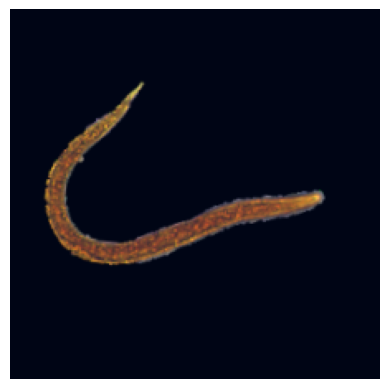

In [9]:
# visualize images from the trainset

print("Number of images:", len(trainset))
image, target = trainset[4] # it executes getitem
image     = image.permute(1,2,0).numpy()
image     = 255*(image - np.min(image))/(np.max(image)-np.min(image))
image     = image.astype('uint8')
print("Images are {}x{}x{}".format(width,height,nchannels))
plt.imshow(image)
plt.axis('off')
print("Class of the image: ", target+1)
plt.show()

In [10]:
batchsize = 32
trainload = DataLoader(trainset, batch_size=batchsize, shuffle=True)
testload  = DataLoader(testset, batch_size=batchsize, shuffle=True)
validload = DataLoader(validset, batch_size=batchsize, shuffle=True)

next(iter(trainload)) # inspect next item in the trainload

[tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
           [-

Adding Residual Blocks to the net

In [11]:
class ResidualBlock(nn.Module):
    """
    A residual block with two convolutional layers.
    Includes a shortcut connection that adds the input to the output.
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        # main path will have two convolutions
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        # shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.conv_block(x) + self.shortcut(x)
        out = self.relu(out)
        return out

class LarvaNetV3(nn.Module):
    """
    A new version of the LarvaNet using Residual Blocks.
    """
    def __init__(self, input_shape, num_classes):
        super(LarvaNetV3, self).__init__()

        # Initial convolution layer (similar to ResNet architecture)
        self.in_channels = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape[0], self.in_channels, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.in_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        ) # Output size: 224 -> 112 -> 56x56

        # Stacking Residual Blocks
        self.layer1 = self._make_layer(ResidualBlock, 64, num_blocks=2, stride=1)  # Output: 56x56
        self.layer2 = self._make_layer(ResidualBlock, 128, num_blocks=2, stride=2) # Output: 28x28
        self.layer3 = self._make_layer(ResidualBlock, 256, num_blocks=2, stride=2) # Output: 14x14
        self.layer4 = self._make_layer(ResidualBlock, 512, num_blocks=2, stride=2) # Output: 7x7

        # Classifier part
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        # Helper function to create a layer of residual blocks
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for s in strides:
            layers.append(block(self.in_channels, out_channels, s))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out


In [12]:
model_v3 = LarvaNetV3(input_shape, nclasses).to(device)
summary(model_v3, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
    ResidualBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [15]:
def Criterion(model, preds, targets):
    ce            = nn.CrossEntropyLoss().to(device)
    loss          = ce(preds, targets.long())
    # add l2_regularization
    l2_regularization = 0
    for param in model.parameters():
        l2_regularization += torch.norm(param,2)
    loss += 0.0001*l2_regularization # 0.0001 is the weight_decay
    # compute mean accuracy in the batch
    pred_labels   = torch.max(preds, 1)[1] # same as argmax
    acc           = torch.sum(pred_labels == targets.data)
    n             = pred_labels.size(0)
    acc           = acc/n
    return loss, acc


criterion = Criterion

In [16]:
optimizer_v3    = optim.Adam(model_v3.parameters(), lr=1e-4)
lr_scheduler_v3 = optim.lr_scheduler.StepLR(optimizer_v3, step_size=25, gamma=0.9)

In [17]:
def train_batch(model, data, optimizer, criterion, device):
    model.train()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss, acc = criterion(model, preds, targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion, device):
    model.eval()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss, acc = criterion(model, preds, targets)
    return loss.item(), acc.item()

In [ ]:
patience = 15 # Number of epochs to wait for improvement before stopping
patience_counter = 0
best_val_loss = float('inf') # Initialize best validation loss to infinity
best_model_weights = None

n_epochs = 100
log = Report(n_epochs)


for ex in range(n_epochs):


    running_trn_loss = 0.0
    running_trn_acc = 0.0
    N = len(trainload)
    for bx, data in enumerate(trainload):
        loss, acc = train_batch(model_v3, data, optimizer_v3, criterion, device) # Using model_v3 and optimizer_v3
        running_trn_loss += loss
        running_trn_acc += acc
        log.record((ex+(bx+1)/N), trn_loss=loss, trn_acc=acc, end='\r')
    epoch_trn_loss = running_trn_loss / N
    epoch_trn_acc = running_trn_acc / N


    running_val_loss = 0.0
    running_val_acc = 0.0
    N_val = len(validload)
    val_preds_list = []
    val_targets_list = []

    for bx, data in enumerate(validload):
        loss, acc = validate_batch(model_v3, data, criterion, device)
        running_val_loss += loss
        running_val_acc += acc
        log.record((ex+(bx+1)/N_val), val_loss=loss, val_acc=acc, end='\r')

        model_v3.eval()
        with torch.no_grad():
            ims, targets = data
            ims, targets = ims.to(device), targets.to(device)
            preds = model_v3(ims)
            pred_labels = torch.max(preds, 1)[1]
            val_preds_list.extend(pred_labels.cpu().numpy())
            val_targets_list.extend(targets.cpu().numpy())

    epoch_val_loss = running_val_loss / N_val
    epoch_val_acc = running_val_acc / N_val
    kappa = cohen_kappa_score(val_targets_list, val_preds_list)
    log.record(ex+1, val_kappa=kappa, end='\r')


    if (ex + 1) % 5 == 0:
            print(f"--EPOCH: {ex+1}  ",
                  f"Trn_Loss: {epoch_trn_loss:.4f}  ",
                  f"Trn_Acc: {epoch_trn_acc:.4f}  ",
                  f"Val_Loss: {epoch_val_loss:.4f}  ",
                  f"Val_Acc: {epoch_val_acc:.4f}  ",
                  f"Val_Kappa: {kappa:.4f}  ",
                  f"Patience: {patience_counter}/{patience}")

    lr_scheduler_v3.step()


    if epoch_val_loss < best_val_loss:
        # if validation loss improves, save the model state and reset the counter
        best_val_loss = epoch_val_loss
        best_model_weights = model_v3.state_dict().copy() # Save the best model weights
        patience_counter = 0
        print(f"Validation loss improved. Best val_loss: {best_val_loss:.4f}")
    else:
        # if validation loss does not improve, increment the counter
        patience_counter += 1
        print(f"Validation loss did not improve. Patience counter: {patience_counter}/{patience}")

    if patience_counter >= patience:
        # If the counter reaches the patience limit, stop training
        print(f"Early stopping triggered after {patience} epochs without improvement.")
        break


if best_model_weights:
    print("\nLoading best model weights found during training.")
    model_v3.load_state_dict(best_model_weights)

print("\nTraining finished.")

EPOCH: 1.000  val_kappa: 0.801  (11.92s - 1180.34s remaining)Validation loss improved. Best val_loss: 0.2120
EPOCH: 2.000  val_kappa: 0.706  (23.93s - 1172.49s remaining)Validation loss did not improve. Patience counter: 1/15
EPOCH: 3.000  val_kappa: 0.447  (35.88s - 1160.22s remaining)Validation loss did not improve. Patience counter: 2/15
EPOCH: 4.000  val_kappa: 0.706  (48.71s - 1169.07s remaining)Validation loss did not improve. Patience counter: 3/15
EPOCH: 5.000  val_kappa: 0.158  (61.52s - 1168.80s remaining)--EPOCH: 5   Trn_Loss: 0.1251   Trn_Acc: 0.9688   Val_Loss: 0.6456   Val_Acc: 0.8594   Val_Kappa: 0.1579   Patience: 3/15
Validation loss did not improve. Patience counter: 4/15
EPOCH: 6.000  val_kappa: 0.558  (73.68s - 1154.33s remaining)Validation loss did not improve. Patience counter: 5/15
EPOCH: 7.000  val_kappa: 0.216  (85.92s - 1141.47s remaining)Validation loss did not improve. Patience counter: 6/15
EPOCH: 8.000  val_kappa: 0.755  (98.04s - 1127.42s remaining)Valida